# Analyse Cifar100 runs using Adam optimizer with various batch sizes
## Time to get to accuracy 0.6 on DL server

In [7]:
%matplotlib inline
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import itertools
from matplotlib import cm
import pandas as pd
import subprocess
import os
from cycler import cycler

In [8]:
logdir="logs/flextime/0_6x100/02_Adam/experiment02"

In [9]:
!ls logs/flextime/0_6x100/02_Adam/experiment02

cifar_adam_flextime_b1024.log cifar_adam_flextime_b384.log
cifar_adam_flextime_b128.log  cifar_adam_flextime_b48.log
cifar_adam_flextime_b1280.log cifar_adam_flextime_b512.log
cifar_adam_flextime_b1536.log cifar_adam_flextime_b64.log
cifar_adam_flextime_b16.log   cifar_adam_flextime_b640.log
cifar_adam_flextime_b24.log   cifar_adam_flextime_b768.log
cifar_adam_flextime_b256.log  cifar_adam_flextime_b8.log
cifar_adam_flextime_b32.log   cifar_adam_flextime_b80.log


In [10]:
filename_pattern=re.compile(r"cifar_.*\.log")

In [11]:
files=[]
comm = "ls -1 "+logdir
proc = subprocess.Popen(comm.split(" "),
                     stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
for line in iter(proc.stdout.readline,b''):
    m = filename_pattern.match(line)
    if m:
        files.append(os.path.abspath(os.path.join(logdir,line)))

In [12]:
batch_pattern = re.compile(r"^b\s*(\d+)")
output_pattern = re.compile(r"^(\d+)\s+([0-9\.]+)\s+([0-9\.]+)\s+([0-9\.]+)\s+([0-9\.]+)\s+([0-9\.]+)")

In [13]:
remove_str="[J"
def readfile(filename,debug=False):
    filename = filename.strip(" \n")
    with open(filename,"r") as f:
        lines = f.readlines()
        batch = 0
        epoch = 0    
        run = 0
        loss = 0
        acc = 0
        time = 0
        df = pd.DataFrame(data=None,columns=["batch","loss","acc","time","epochs"])
        for line in lines:
            s = line.strip('\n')
            s = s.replace(remove_str,"")
            #if debug: print line[:75]
            m = batch_pattern.match(s)        
            if m:
                batch = int(m.group(1))       
                epoch = 0
                run += 1
                if debug: print "New run with:",batch
            else:
                m = output_pattern.match(s)
                if m:
                    epoch = int(m.group(1))                    
                    loss = float(m.group(3))
                    acc = float(m.group(5))
                    time = float(m.group(6))
                    ls = [batch,loss,acc,time,epoch]
                    s = pd.Series([batch,loss,acc,time,epoch], index=["batch","loss","acc","time","epochs"])
                    #if debug: print s.T
                    df = df.append(s,ignore_index=True)
    if debug: print df
    return df

In [14]:
df = pd.DataFrame(data=None,columns=["batch","loss","acc","time","epochs"])
for file in files:
#print files[2]
    df1 = readfile(file)
    #print df1.head()
    if len(df1) > 0:
        df = pd.concat([df,df1],ignore_index=True)
df[df["batch"]==1024].head()

,batch,loss,acc,time,epochs
0,1024.0,4.60610,0.013317,24.1878,1.0
1,1024.0,4.92029,0.010493,47.6043,2.0
2,1024.0,4.92356,0.018274,71.1511,3.0
3,1024.0,4.65935,0.022473,94.7235,4.0
4,1024.0,4.88286,0.024342,118.3490,5.0


/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


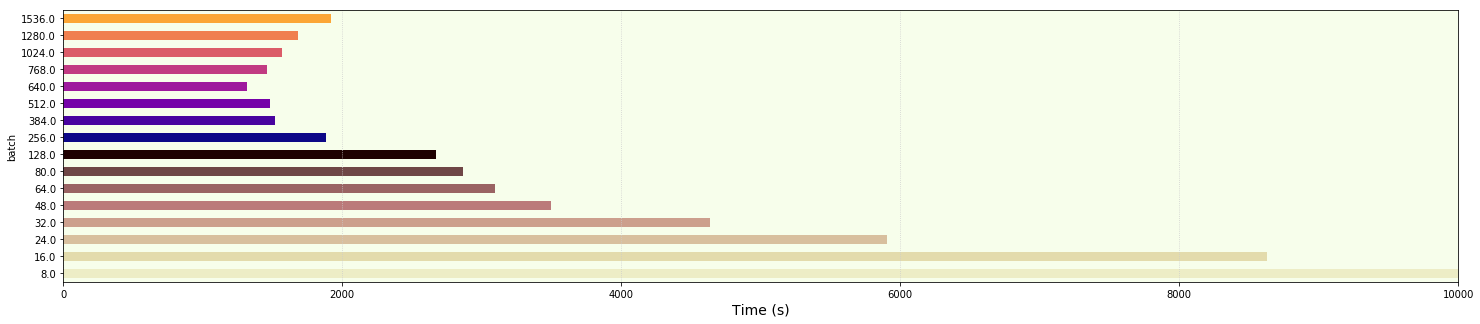

In [15]:
fig, ax = plt.subplots(figsize=(25,5))
max_times = df.groupby(by="batch")["time"].max()
matplotlib.rcParams["font.sans-serif"] = ['Avenir Next Condensed']
font = {'family' : 'sans-serif','weight' : 'normal','size'   : 12}
matplotlib.rc('font', **font)

colors=itertools.chain(iter(cm.pink_r(np.linspace(0.2,1,8))),iter(cm.plasma(np.linspace(0,.8,8))))
max_times.plot.barh(ax=ax,color=colors)
ax.xaxis.grid(linestyle=":",color="#cccccc")
ax.set_xlabel("Time (s)",fontsize=14)
ax.set_xlim(0,10000)
ax.set_facecolor("#F7FEEB")
fig.show()

In [16]:
df_tmp = df.copy()
df_tmp.set_index("time", inplace=True)
df_tmp.head()

,batch,loss,acc,epochs
time,,,,
24.1878,1024.0,4.60610,0.013317,1.0
47.6043,1024.0,4.92029,0.010493,2.0
71.1511,1024.0,4.92356,0.018274,3.0
94.7235,1024.0,4.65935,0.022473,4.0
118.3490,1024.0,4.88286,0.024342,5.0


In [17]:
#color_list = plt.cm.seismic(np.linspace(0, 1, 12))
#print color_list
def getColorList(cmap,n):
    cmap = cm.get_cmap(cmap, n)
    colors = []
    for i in range(cmap.N):
        c = matplotlib.colors.to_hex(cmap(i),keep_alpha=True)
        colors.append(c)
    return colors

Text(1.03,0.97,u'Batch size')

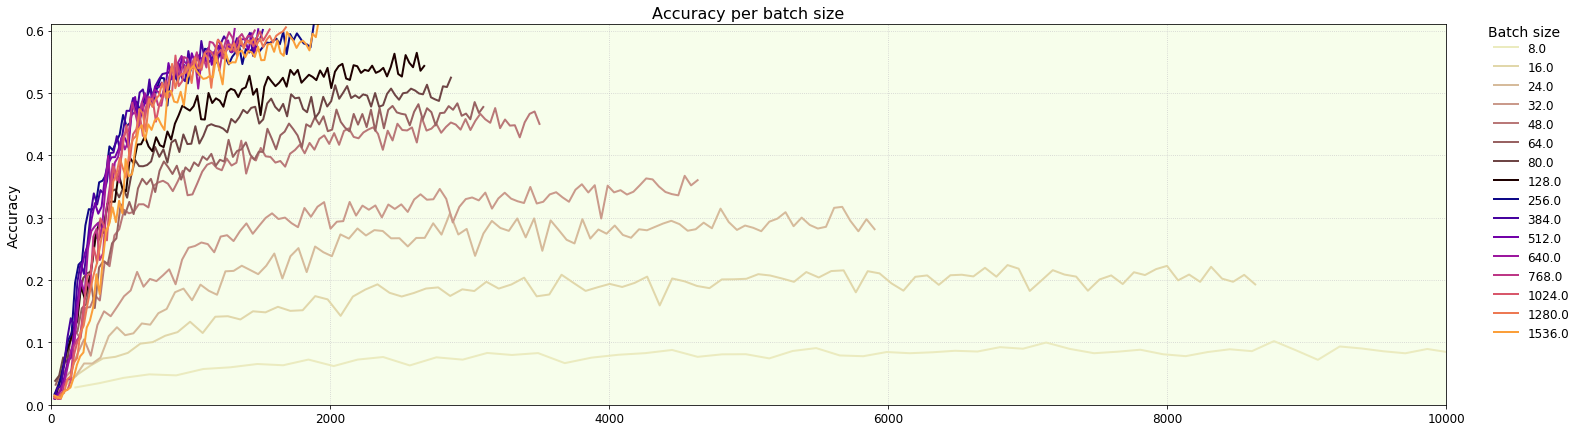

In [18]:
colors1 = getColorList("pink_r",10)
colors2 = getColorList("plasma",10)
colors =  colors1[2:] + colors2[:-2]
plt.rc('axes', prop_cycle=(cycler('color', colors)))
fig,ax = plt.subplots(figsize=(25,7))
df_tmp.groupby("batch")["acc"].plot(kind="line",ax=ax, linewidth=2, legend=True)
ax.set_xlim(0,10000)
ax.set_ylim(0,.61)
plt.legend(bbox_to_anchor=(1.03, 0.97), loc='upper left', borderpad=0, edgecolor="white")
plt.grid(linestyle=":",color="#cccccc")
ax.set_ylabel("Accuracy",fontsize=14)
ax.set_xlabel("")
ax.set_title("Accuracy per batch size",fontsize=16)
ax.set_facecolor("#F7FEEB")
ax.text(1.03, 0.97, 'Batch size', ha='left',fontsize=14,transform=ax.transAxes)